In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [2]:
# Load dataset
df = pd.read_csv("synthetic_procurement_data.csv")

In [3]:
# Convert Award Date to datetime
df["Award Date"] = pd.to_datetime(df["Award Date"])
df["Year"] = df["Award Date"].dt.year
df["Month"] = df["Award Date"].dt.month

In [4]:
# Encode categorical variables
label_enc = LabelEncoder()
df["Country"] = label_enc.fit_transform(df["Country"])
df["Supplier"] = label_enc.fit_transform(df["Supplier"])
df["Risk Score"] = df["Risk Score"].map({"Low": 0, "Medium": 1, "High": 2})

### **Feature Engineering (Adding Year & Month from Award Date)**
**Why?**  
- The **Award Date** might reveal seasonal trends or patterns in corruption cases.  
- Extracting the **Year** and **Month** helps the model detect procurement irregularities tied to specific time periods (e.g., end-of-year budget rush).

**How?**  
- Converted the **Award Date** into a **datetime object**.  
- Extracted **Year** and **Month** as separate features to be used in the model.

In [5]:
# Normalize contract value using log transformation
df["Contract Value (USD)"] = np.log1p(df["Contract Value (USD)"])

# Feature Engineering
features = ["Country", "Supplier", "Contract Value (USD)", "Bidders Count", "Contract Duration (Months)", "Year", "Month"]
X = df[features]

In [6]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Dimensionality Reduction using PCA**
**Why?**  
- High-dimensional data can lead to **overfitting** and increased **computational complexity**.  
- **Principal Component Analysis (PCA)** helps reduce redundancy and focus on the most **informative features**.

**How?**  
- Standardized all numerical features to ensure **equal scale**.  
- Applied **PCA with 5 components**, retaining most of the data variance.  
- The transformed features replace the original high-dimensional data while preserving important patterns.

In [7]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

In [8]:
# Anomaly Detection - Isolation Forest
iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
df["Anomaly"] = iso_forest.fit_predict(X_scaled)

### **One-Class SVM for Additional Anomaly Detection**
**Why?**  
- Fraudulent procurement behavior is rare and doesn't always follow a clear pattern.  
- **One-Class SVM** can help detect outliers by learning the **normal procurement pattern** and flagging deviations.

**How?**  
- Applied **One-Class SVM with RBF kernel**, which is effective for non-linear data.  
- Set **nu=0.05**, assuming that **5% of the data** contains anomalies.  
- Compared results with **Isolation Forest**, using an ensemble approach for better anomaly detection.

In [9]:
# One-Class SVM for Anomaly Detection
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
df["SVM_Anomaly"] = oc_svm.fit_predict(X_scaled)

# Combine anomaly scores
df["Final_Anomaly"] = df[["Anomaly", "SVM_Anomaly"]].sum(axis=1)

### **SMOTE for Handling Class Imbalance**
**Why?**  
- Corruption risk categories (**Low, Medium, High**) are likely **imbalanced** (fewer high-risk cases).  
- Imbalanced data leads to biased models that favor the majority class.

**How?**  
- Used **Synthetic Minority Over-sampling Technique (SMOTE)** to generate **synthetic samples** for the minority classes.  
- Ensured the dataset had a more balanced distribution before training the model.

In [10]:
# Train-Test Split for Risk Classification
X_train, X_test, y_train, y_test = train_test_split(X, df["Risk Score"], test_size=0.2, random_state=42, stratify=df["Risk Score"])

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### **GridSearchCV for Random Forest Hyperparameter Tuning**
**Why?**  
- Instead of manually tweaking hyperparameters, **GridSearchCV** automates this process and finds the best combination.  
- Optimizing hyperparameters improves model **accuracy** and **generalization**.

**How?**  
- Defined a parameter grid with different values for:
  - **n_estimators** (number of trees),
  - **max_depth** (depth of trees),
  - **min_samples_split** (minimum samples needed for a split),
  - **min_samples_leaf** (minimum samples per leaf node).  
- Ran **5-fold cross-validation** to evaluate performance across different splits.  
- Selected the best model based on **highest accuracy score**.

In [11]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_clf = grid_search.best_estimator_

# Predictions
y_pred = best_clf.predict(X_test)

# Model Evaluation
print("\nBest Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       286
           1       1.00      0.97      0.98        33
           2       1.00      1.00      1.00      1681

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000


Accuracy Score: 0.9995


### **Confusion Matrix for Model Evaluation**
**Why?**  
- A **confusion matrix** gives a **detailed breakdown** of how the model performs in each risk category.  
- Unlike accuracy alone, it shows **false positives and false negatives**, which are crucial in fraud detection.

**How?**  
- Plotted a **heatmap confusion matrix** using **Seaborn**.  
- Evaluated how many **low-risk, medium-risk, and high-risk** cases were classified correctly and where errors occurred.  
- Used insights to fine-tune the model further.

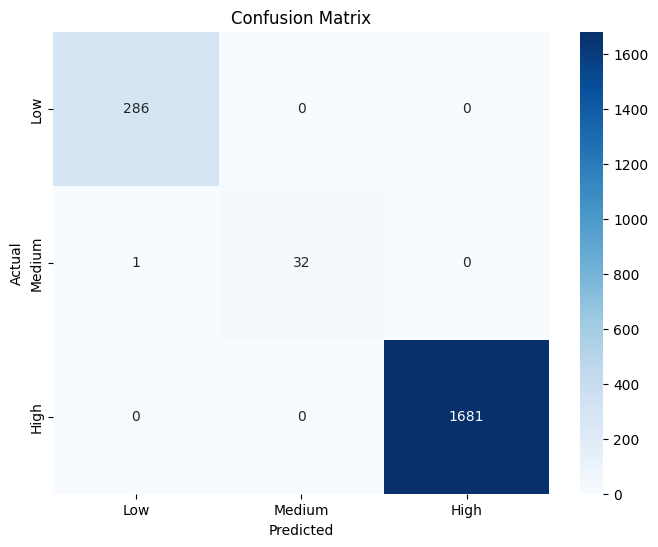

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

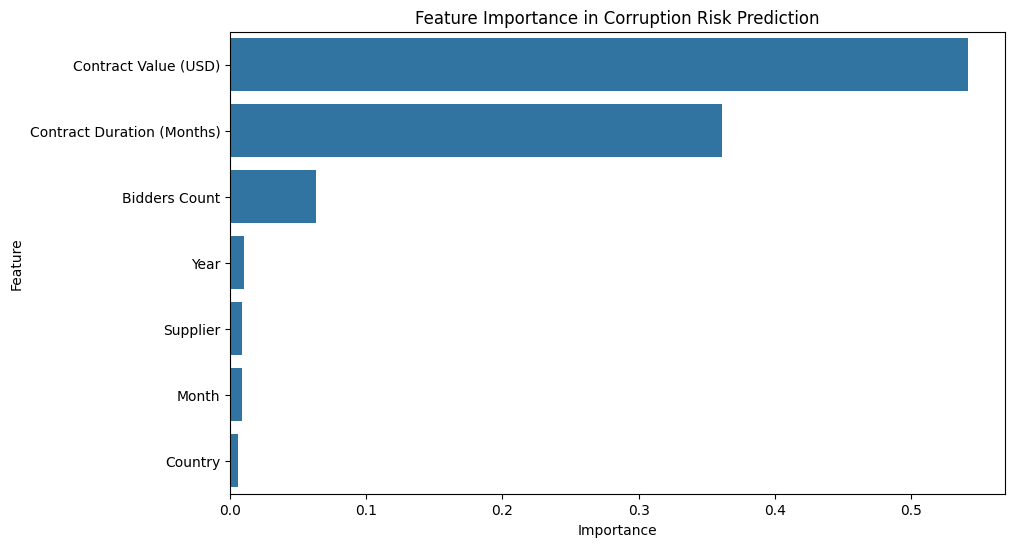

In [13]:
# Feature Importance
importances = best_clf.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance in Corruption Risk Prediction")
plt.show()